<a href="https://colab.research.google.com/github/Nikhild2710/Churn-prediction/blob/main/Churn_predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Mount Google Drive if you want to save outputs
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/.kaggle"
DATA_DIR = "/content/drive/MyDrive/churn-predictor"
os.makedirs(DATA_DIR, exist_ok=True)

!pip -q install kaggle

In [4]:
import os, stat

cfg_path = "/content/drive/MyDrive/.kaggle/kaggle.json"
assert os.path.exists(cfg_path), f"Missing {cfg_path}. Upload your kaggle.json there."

# Permissions 600 are recommended
os.chmod(cfg_path, stat.S_IRUSR | stat.S_IWUSR)
print("kaggle.json present and permissions set.")


kaggle.json present and permissions set.


In [5]:
!kaggle datasets download -d blastchar/telco-customer-churn -p $DATA_DIR -q
!unzip -o $DATA_DIR/telco-customer-churn.zip -d $DATA_DIR
!ls -la $DATA_DIR


Dataset URL: https://www.kaggle.com/datasets/blastchar/telco-customer-churn
License(s): copyright-authors
Archive:  /content/drive/MyDrive/churn-predictor/telco-customer-churn.zip
  inflating: /content/drive/MyDrive/churn-predictor/WA_Fn-UseC_-Telco-Customer-Churn.csv  
total 1127
-rw------- 1 root root 175758 Sep 27  2019 telco-customer-churn.zip
-rw------- 1 root root 977501 Sep 27  2019 WA_Fn-UseC_-Telco-Customer-Churn.csv


In [6]:
import pandas as pd

CSV_PATH = f"{DATA_DIR}/WA_Fn-UseC_-Telco-Customer-Churn.csv"
df = pd.read_csv(CSV_PATH)
print(df.shape)
df.head()


(7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [7]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)
df.drop(columns=['customerID'], inplace=True)
df['Churn'] = df['Churn'].map({'Yes':1, 'No':0})
df['Churn'].value_counts(normalize=True)


/tmp/ipython-input-2693752312.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)


,proportion
Churn,
0,0.73463
1,0.26537


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from xgboost import XGBClassifier

X = df.drop('Churn', axis=1)
y = df['Churn']

cat_cols = X.select_dtypes(include='object').columns.tolist()
num_cols = X.select_dtypes(exclude='object').columns.tolist()

pre = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
])

# scale_pos_weight ~ (negatives/positives) ≈ 2.5–3 for this dataset
clf = Pipeline([
    ("pre", pre),
    ("xgb", XGBClassifier(
        n_estimators=400,
        max_depth=4,
        learning_rate=0.06,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_lambda=1.0,
        scale_pos_weight=3,
        eval_metric="logloss",
        random_state=42
    ))
])

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
clf.fit(X_tr, y_tr)
pred = clf.predict(X_te)
print(classification_report(y_te, pred, digits=4))


              precision    recall  f1-score   support

           0     0.8957    0.7469    0.8145      1035
           1     0.5201    0.7594    0.6174       374

    accuracy                         0.7502      1409
   macro avg     0.7079    0.7531    0.7160      1409
weighted avg     0.7960    0.7502    0.7622      1409



/tmp/ipython-input-2117871680.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=corr.values, y=corr.index, palette="coolwarm")


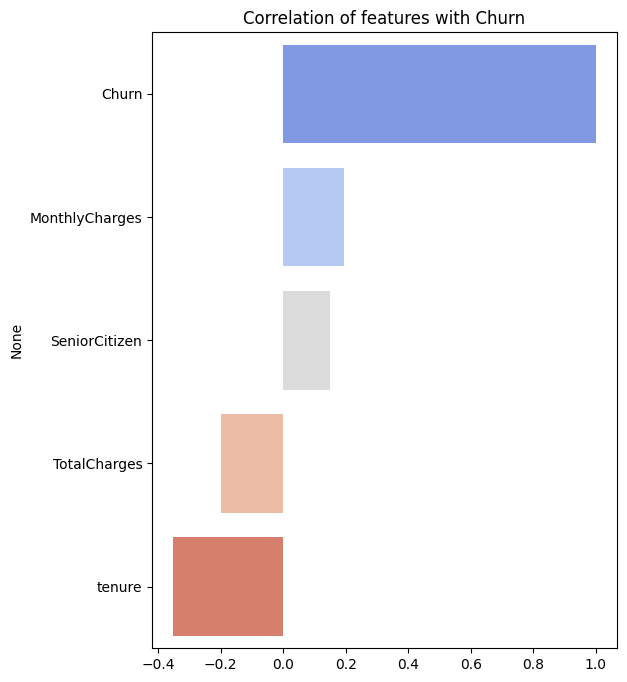

,Churn
Churn,1.000000
MonthlyCharges,0.193356
SeniorCitizen,0.150889
TotalCharges,-0.199037
tenure,-0.352229


In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# For correlation, churn must be numeric (already 0/1)
corr = df.corr(numeric_only=True)['Churn'].sort_values(ascending=False)

plt.figure(figsize=(6,8))
sns.barplot(x=corr.values, y=corr.index, palette="coolwarm")
plt.title("Correlation of features with Churn")
plt.show()

corr


/tmp/ipython-input-4048480192.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_imp.head(20), y='feature', x='importance', palette="viridis")


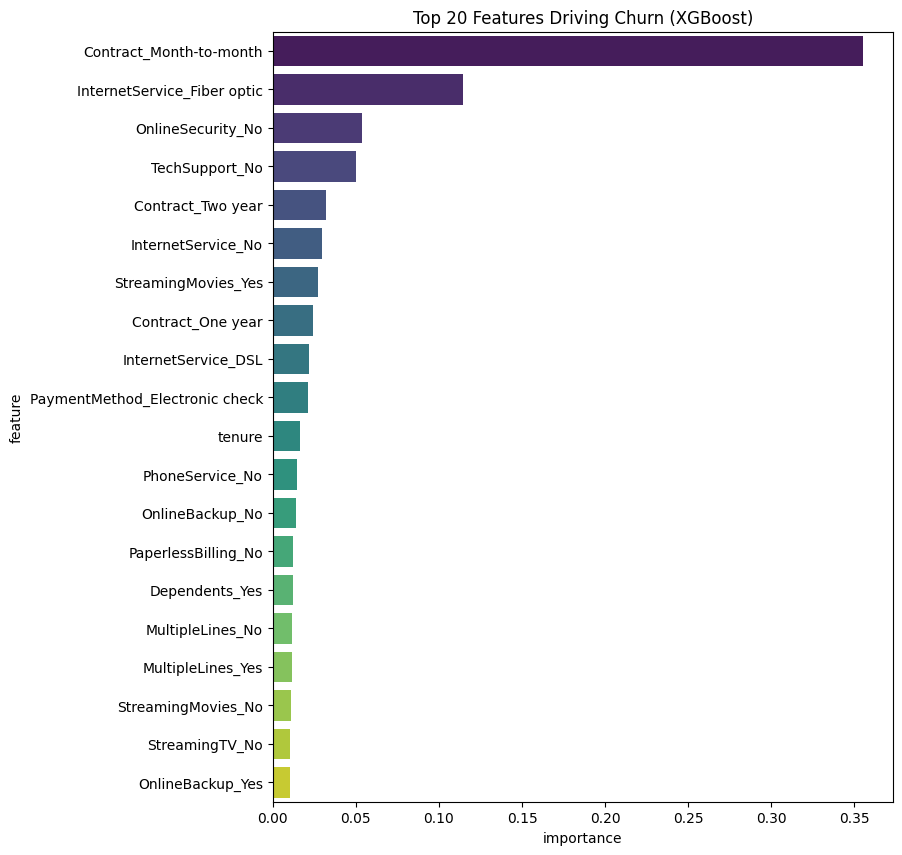

In [10]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Get feature names after preprocessing
ohe = clf.named_steps['pre'].transformers_[1][1]  # OneHotEncoder step
cat_features = ohe.get_feature_names_out(cat_cols)
all_features = np.concatenate([num_cols, cat_features])

# Extract feature importances from the fitted XGBClassifier
xgb_model = clf.named_steps['xgb']
importances = xgb_model.feature_importances_

feat_imp = pd.DataFrame({'feature': all_features, 'importance': importances})
feat_imp = feat_imp.sort_values('importance', ascending=False)

# Plot top 20
plt.figure(figsize=(8,10))
sns.barplot(data=feat_imp.head(20), y='feature', x='importance', palette="viridis")
plt.title("Top 20 Features Driving Churn (XGBoost)")
plt.show()


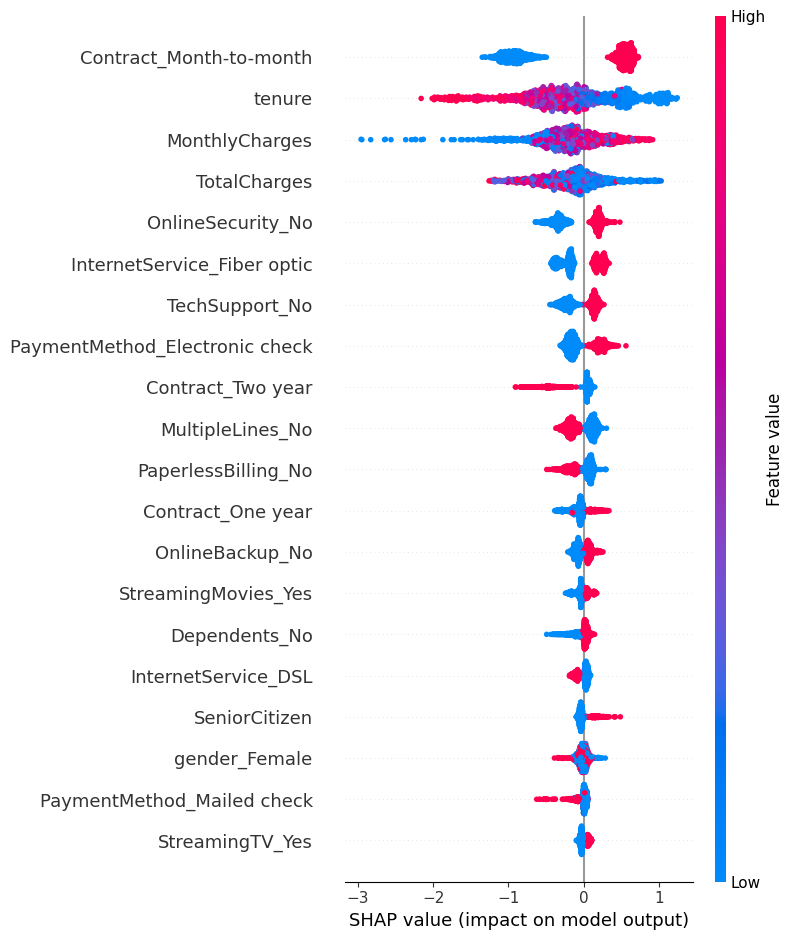

In [11]:
import shap

# Create SHAP explainer on the trained XGB model
explainer = shap.TreeExplainer(xgb_model)
X_test_trans = clf.named_steps['pre'].transform(X_te)

# Compute SHAP values for the test set
shap_values = explainer.shap_values(X_test_trans)

# Global feature importance (summary)
shap.summary_plot(shap_values, features=X_test_trans, feature_names=all_features)


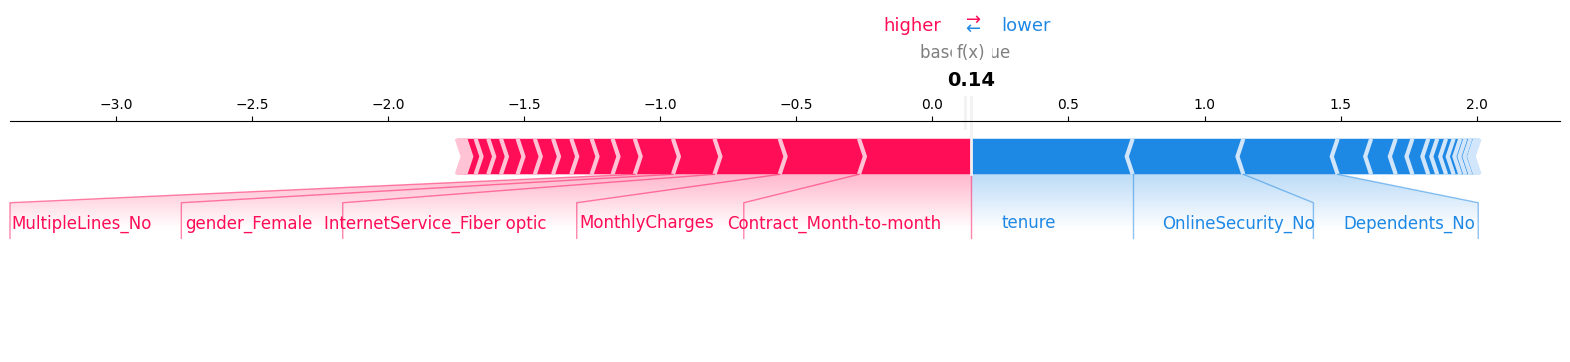

In [12]:
# Pick one customer from test set
i = 10
shap.force_plot(explainer.expected_value, shap_values[i,:], feature_names=all_features, matplotlib=True)
